# Imports

In [7]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader
import torchvision.transforms as T
import os
from torch.utils.data import random_split
from PIL import Image
import pandas as pd
import numpy as np
import glob
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Vehicle Dataset

In [8]:
class Traffic(Dataset):
  def __init__(self, root_dir, transform=None, loader=default_loader):
    
    self.image_paths, self.labels_path = self._get_imgs_and_labels(root_dir)
    
    self.transform = transform
    self.loader = loader
    
  def __len__(self):
    return len(self.image_labels)
  
  def __getitem__(self, index):
    image = self.loader(self.image_paths[index])
    label = self.labels_path[index]

    if self.transform:
      image = self.transform(image)
  
    return image, torch.tensor(int(label)-1) # Convert labels to tensors, and subtract 1 for convention purposes (to start at 0)
  
  # Helper Functions
  def print_image(self, index):
    img = Image.open(self.image_paths[index])
    print(self.image_paths[index])
    print(self.labels_path[index])
    img.show()

  def _get_imgs_and_labels(self, root_dir):
    image_full_path = []
    labels_full_path = []
    
    # Get paths to each image (in order)
    for img_path in sorted(glob.glob(os.path.join(root_dir, "images", "train", "*.jpg"))):
      image_full_path.append(img_path)
    
    # Get the label paths
    for label in sorted(glob.glob(os.path.join(root_dir, "labels", "train", "*.txt"))):
      labels_full_path.append(label)
    
    return image_full_path, labels_full_path
  
  
  """def process(self, output_dir):
    counter = 0
    with open('annotations.txt', 'w') as annotations:
      for i in range(len(self.image_paths)):
        image = self.loader(self.image_paths[i])
        label = self.labels_path[i]

        with open(label, 'r') as f:
            labels = f.readlines()

        for label in labels:
            _class, x, y, width, height = map(float, label.strip().split())
            x1 = int((x - width / 2) * image.size[0])
            x2 = int((x + width / 2) * image.size[0])
            y1 = int((y - height / 2) * image.size[1])
            y2 = int((y + height / 2) * image.size[1])
            cropped_image = image.crop((x1, y1, x2, y2))
            
            if cropped_image.size[0] <= 0 or cropped_image.size[1] <= 0:
              continue
            
            else:
              output_filename = f"{counter:04d}.jpg"
              counter += 1
              output_path = os.path.join(output_dir, "images", output_filename)
              cropped_image.save(output_path)
              
              annotations.write(f"{int(_class)}\n")"""
            
            
            



In [9]:
class Traffic(Dataset):
  def __init__(self, root_dir, transform=None, loader=default_loader):
    
    self.image_paths, self.labels = self._get_imgs_and_labels(root_dir)
    
    self.transform = transform
    self.loader = loader
    
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    image = self.loader(self.image_paths[index])
    label = self.labels[index]

    if self.transform:
      image = self.transform(image)
  
    return image, torch.tensor(int(label)-1) # Convert labels to tensors, and subtract 1 for convention purposes (to start at 0)
  
  # Helper Functions
  def print_image(self, index):
    img = Image.open(self.image_paths[index])
    img.show()
    print(self.labels[index])

  def _get_imgs_and_labels(self, root_dir):
    image_full_path = []
    labels = []
    
    # Get paths to each image (in order)
    for img_path in sorted(glob.glob(os.path.join(root_dir, "images", "*.jpg"))):
      image_full_path.append(img_path)
    
    # Get labels
    with open(os.path.join(root_dir, "annotations.txt"), 'r') as f:
      for label in f:
        labels.append(int(label.strip()) + 1)
    
    return image_full_path, labels

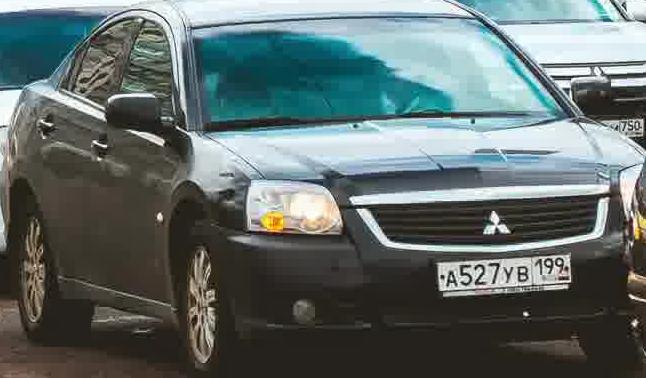

1


In [10]:
data_dir = "Traffic_Processed"

data = Traffic(root_dir=data_dir, transform=T.ToTensor())

data.print_image(10)

# CNN

In [54]:
class Convolutional(nn.Module):
  def __init__(self, in_channels=3):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                                                                        
    )
    self.linear = nn.Sequential(nn.Dropout(p=0.5),
                                nn.Linear(in_features=100352, out_features=4608),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(in_features=4608, out_features=7),
                                # nn.Softmax(dim=1)
                                )
  
  def forward(self, x):
    x = self.conv(x)
    b, c, h, w = x.shape
    x = x.view(b, -1) # Flatten image
    x = self.linear(x)
    
    return x

# Training

2441
3488
Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([32, 3, 224, 224]), torch.Size([32])
Labels: tensor([2, 0, 0, 6, 1, 2, 4, 6, 5, 3, 6, 3, 2, 3, 0, 1, 0, 0, 0, 0, 0, 6, 0, 4,
        0, 0, 0, 3, 0, 2, 0, 1])

tensor(2)
tensor(0)
tensor(0)


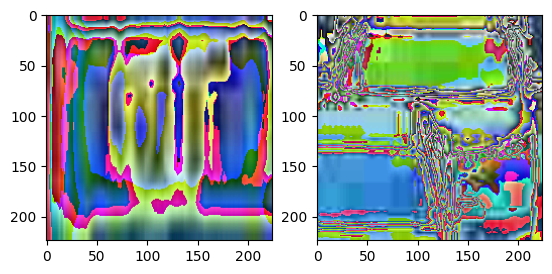

In [55]:
data_dir = "./Traffic_Processed"

transform = T.Compose ([
  T.Resize((224, 224)),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

vehicle_data = Traffic(root_dir=data_dir, transform=transform)

train_data_size = int(len(vehicle_data) * .5) 
validation_data_size = int(len(vehicle_data) * .2)

print(train_data_size + validation_data_size)
print(len(vehicle_data))
other = len(vehicle_data) - (train_data_size + validation_data_size)

train_data, val_data, other = random_split(vehicle_data, [train_data_size, validation_data_size, other])

train = DataLoader(vehicle_data, batch_size=32, shuffle=True)

data = iter(train) # Let's iterate on it
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")

print(single_point[1][0])
print(single_point[1][1])
print(single_point[1][2])

import matplotlib.pyplot as plt
from torchvision import transforms as T
ToPIL = T.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0])
img1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
axs[0].imshow(img0)
axs[1].imshow(img1)

In [59]:
# We're going to reload the data here so we have added clarity

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []

def train_model(optimizer,model,device,scheduler,nepochs,LossFunction,loss_history,batch_size):
    
    train_dataloader = DataLoader(train_data,batch_size=batch_size)
    val_dataloader = DataLoader(val_data,batch_size=batch_size)
    
    # This is default on but let's just be pedantic
    model.train()
    loss = torch.Tensor([0])
    correct = 0
    total = 0
    for epoch in tqdm(range(nepochs),
                    desc=f"Epoch",
                    unit="epoch",
                    disable=False):
        for (data, label) in tqdm(train_dataloader,
                                desc="iteration",
                                unit="%",
                                disable=True):
            optimizer.zero_grad(set_to_none=True) # Here we clear the gradients
            
            # We need to make sure the tensors are on the same device as our model
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            
            loss = LossFunction(out, label)
            # PyTorch is Magic!
            loss.backward() # This function calculates all our gradients
            optimizer.step() # This function does our gradient descent with those gradients
            
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
        accuracy = 100 * correct / total
        acc_history.append(accuracy)
        print(f"Training Acc: {accuracy}%")
        loss_history.append(loss.item())
        
        # Validation
        model.eval() # No longer training - comparing loss and accuracy in our validation set
        correct = 0
        total = 0
        with torch.no_grad(): # Don't want to update the gradients
            for (data, label) in val_dataloader:
                data = data.to(device)
                label = label.to(device)
                out = model(data)
                loss = LossFunction(out, label)

                # Used chatGPT to help write this accuracy code     
                _, predicted = torch.max(out.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
                
            accuracy = 100 * correct / total
            val_acc_history.append(accuracy)
            val_loss_history.append(loss.item())
            print(f"Val Acc: {accuracy}%")
            
            
        print(f"learning rate: {scheduler.get_last_lr()}")
        print(f"Epoch {epoch}: loss: {loss.item()}")
                
        # if (scheduler):
        #     scheduler.step()
    
    plot(loss_history)
    plot(acc_history, label2="Accuracy", title="NN Accuracy")

def plot(loss_history, label1="Number of Iterations",label2="Loss",title="Neural Network Loss"):
    plt.plot(loss_history)
    plt.title(title)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.show()
    

In [60]:
def set_hyper_and_run(nepochs,LossFunction,batch_size,model,learning_rate,device, SGD=True):
    loss_history=[]
    if SGD:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        # need to change learning rate to get Adam to converge
        optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=.2)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[2,4],gamma=0.4)
    print(model)
    train_model(optimizer,model,device,scheduler,nepochs,LossFunction,loss_history,batch_size)

# HyperParameters
### Run Training Here

Using GPU: NVIDIA GeForce RTX 2070 SUPER
Convolutional(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=100352, out_features=4608, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4608, out_features=7, bias=True)
  )
)


Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training Acc: 54.12844036697248%


Epoch:  10%|█         | 1/10 [01:41<15:16, 101.87s/epoch]

Val Acc: 54.37589670014347%
learning rate: [0.01]
Epoch 0: loss: 1.1083085536956787
Training Acc: 57.886112249078245%


Epoch:  20%|██        | 2/10 [03:23<13:32, 101.52s/epoch]

Val Acc: 57.53228120516499%
learning rate: [0.01]
Epoch 1: loss: 1.086422324180603
Training Acc: 63.37566571077427%


Epoch:  30%|███       | 3/10 [05:03<11:45, 100.80s/epoch]

Val Acc: 57.81922525107604%
learning rate: [0.01]
Epoch 2: loss: 1.0620301961898804
Training Acc: 66.61204424416223%


Epoch:  40%|████      | 4/10 [06:43<10:03, 100.66s/epoch]

Val Acc: 63.41463414634146%
learning rate: [0.01]
Epoch 3: loss: 0.9230613112449646
Training Acc: 72.06063088897993%


Epoch:  50%|█████     | 5/10 [08:23<08:21, 100.23s/epoch]

Val Acc: 67.43185078909613%
learning rate: [0.01]
Epoch 4: loss: 0.7879750728607178
Training Acc: 76.0344121261778%


Epoch:  60%|██████    | 6/10 [10:02<06:40, 100.04s/epoch]

Val Acc: 73.74461979913917%
learning rate: [0.01]
Epoch 5: loss: 0.666623055934906
Training Acc: 81.31913150348218%


Epoch:  70%|███████   | 7/10 [11:42<05:00, 100.09s/epoch]

Val Acc: 76.04017216642755%
learning rate: [0.01]
Epoch 6: loss: 0.5673434734344482
Training Acc: 83.24457189676362%


Epoch:  80%|████████  | 8/10 [13:20<03:18, 99.35s/epoch] 

Val Acc: 75.32281205164993%
learning rate: [0.01]
Epoch 7: loss: 0.5952997803688049
Training Acc: 86.89061859893486%


Epoch:  90%|█████████ | 9/10 [14:58<01:38, 98.95s/epoch]

Val Acc: 78.7661406025825%
learning rate: [0.01]
Epoch 8: loss: 0.5047282576560974
Training Acc: 89.75829578041787%


Epoch: 100%|██████████| 10/10 [16:35<00:00, 99.58s/epoch]

Val Acc: 78.62266857962697%
learning rate: [0.01]
Epoch 9: loss: 0.4800187647342682


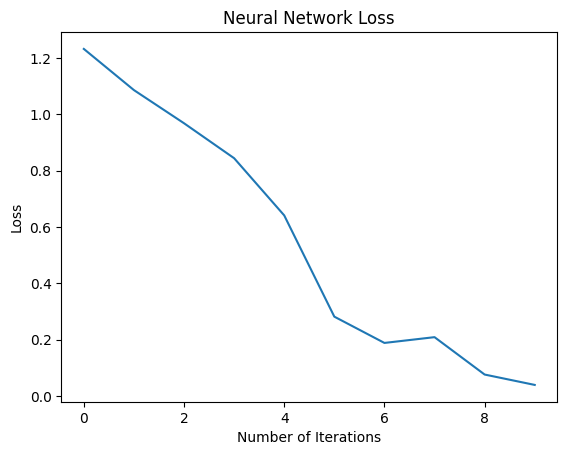

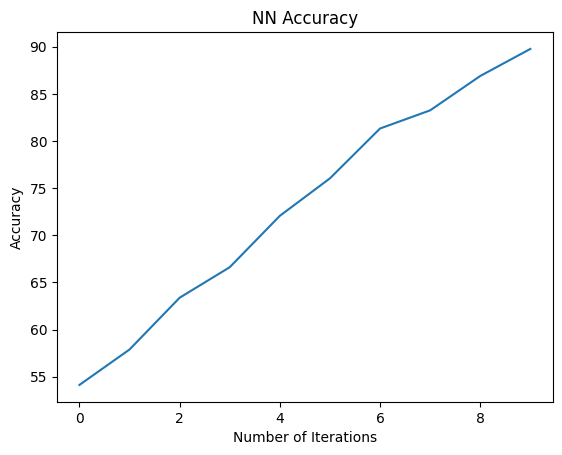

In [61]:
if torch.cuda.is_available():
    device = torch.device("cpu")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

nepochs = 10
LossFunction = nn.CrossEntropyLoss()  
batch_size = 32
model = Convolutional().to(device)
lr = .01
optimizer = optim.SGD(model.parameters(), lr=lr)


set_hyper_and_run(nepochs, LossFunction, batch_size, model, lr, device)

In [63]:
model.eval()
accuracy = 0
total = 0
total2 = 0

val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test = DataLoader(other, batch_size=32, shuffle=True)

for (data, label) in test:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum(0)
    
print(f"Total accuracy = {accuracy / len(other)*100:.2f}%")

torch.save(model.state_dict(), "model_epoch_{}.pt".format(1))

Total accuracy = 76.89%


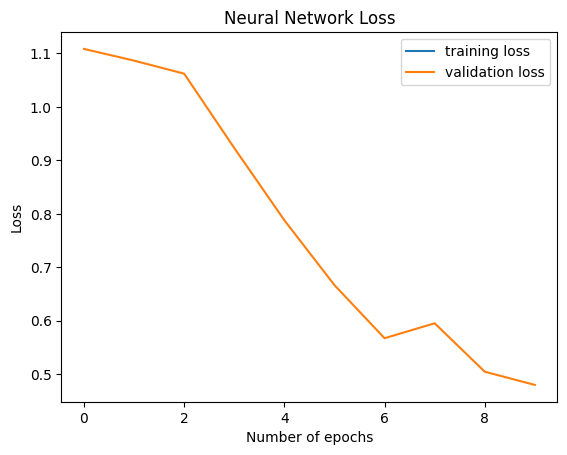

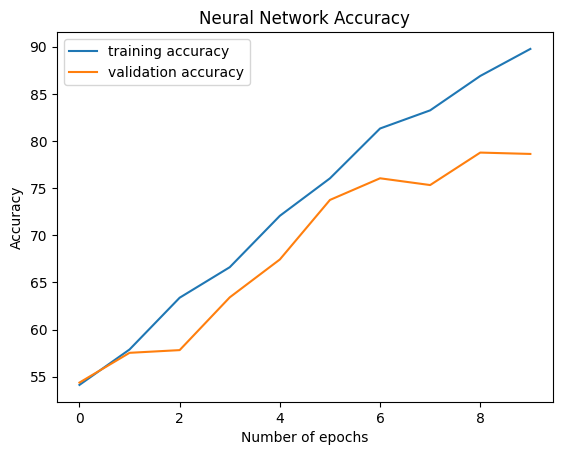

In [64]:
plt.plot(loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='training accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()